In [1]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image

In [2]:
#图片路径
img_path = 'test_img/cat_dog.jpg'     # 输入图片的路径
save_path = 'output/dog.jpg' 

In [3]:
#图片预处理
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(512),
                                     # transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [4]:
#导入模型
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = resnet50(weights=ResNet50_Weights.DEFAULT).eval().to(device)

In [5]:
#输入图片
img_pil = Image.open(img_path)
# 图片预处理
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) 

In [6]:
hook_layer = model.layer4[-1]

In [7]:
feature_map = []     # 建立列表容器，用于盛放输出特征图

def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入列表feature_map

hook_layer.register_forward_hook(forward_hook)    # 对model.layer4[-1]这一层注册前向传播

In [8]:
grad = []     # 建立列表容器，用于盛放特征图的梯度

def backward_hook(module, inp, outp):    # 定义hook 
    grad.append(outp)    # 把输出装入列表grad

hook_layer.register_full_backward_hook(backward_hook)    # 对model.layer4[-1]这一层注册反向传播

In [9]:
out = model(input_tensor)     # 前向传播 
# cls_idx = torch.argmax(out).item()    # 获取预测类别编码 
cls_idx = 231
score = out[:, cls_idx].sum()    # 获取预测类别分数
model.zero_grad() 
score.backward(retain_graph=True)    # 由预测类别分数反向传播

In [10]:
grad[0][0].size()

torch.Size([1, 2048, 16, 24])

In [11]:
weights = grad[0][0].squeeze(0).mean(dim=(1, 2))    # 移除多余的维度，然后在第 1 维和第 2 维上计算平均值，最终得到一个权重向量 weights

In [12]:
mean_values = feature_map[0].squeeze(0).mean(dim=(1, 2))  #GAP(Ak)

In [13]:
donation_values = mean_values * weights
donation_values

tensor([-4.5106e-07, -0.0000e+00,  3.8026e-08,  ...,  2.9196e-08,
         4.3857e-07, -1.4965e-07], device='cuda:0', grad_fn=<MulBackward0>)

In [14]:
max_value, max_index = torch.max(donation_values, dim=0)  

print("最大值:", max_value.item())       # 输出最大值  
print("最大值的索引:", max_index.item())  # 输出索引

最大值: 0.0003597485483624041
最大值的索引: 937


In [15]:
#grad_cam流程
grad_cam = (weights.view(*weights.shape, 1, 1) * feature_map[0].squeeze(0)).sum(0)

In [16]:
#定义归一化函数
def _normalize(cams: Tensor) -> Tensor:
        """CAM normalization"""
        cams.sub_(cams.flatten(start_dim=-2).min(-1).values.unsqueeze(-1).unsqueeze(-1))
        cams.div_(cams.flatten(start_dim=-2).max(-1).values.unsqueeze(-1).unsqueeze(-1))

        return cams

In [17]:
import numpy as np
# 对类激活图执行ReLU激活和归一化  
grad_cam = _normalize(F.relu(grad_cam, inplace=True)).cpu()  

# 确保 grad_cam 在 0-1 之间并转换为 PIL 图像  
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())  # 归一化到 [0, 1] 范围  
mask = to_pil_image(grad_cam.mul(255).add_(0.5).clamp_(0, 255).detach().numpy().astype(np.uint8))

In [18]:
import matplotlib as mpl
#将两个图像交叠融合的过程封装成了函数
def overlay_mask(img: Image.Image, mask: Image.Image, colormap: str = 'jet', alpha: float = 0.6) -> Image.Image:  
    """  
    将掩膜应用颜色映射后，与背景图像叠加  

    Args:  
        img: 背景图像（PIL Image）  
        mask: 单通道掩膜图像（PIL Image）  
        colormap: 颜色映射名称，用于将单通道转为彩色，默认为'jet'  
        alpha: 背景图像的透明度，0.0完全透明，1.0完全不透明，默认为0.6  

    Returns:  
       叠加后的PIL Image对象  
    """  
    # 验证输入类型  
    if not isinstance(img, Image.Image) or not isinstance(mask, Image.Image):  
        raise TypeError('img和mask必须是PIL.Image类型')  

    # 验证alpha值范围  
    if not isinstance(alpha, float) or alpha < 0.0 or alpha >= 1.0:  
        raise ValueError('alpha必须是0.0到1.0之间的浮点数')  

    # 获取颜色映射  
    cmap = mpl.colormaps[colormap] 
    # cmap = cm.get_cmap(colormap)  

    # 将mask调整为与img相同的大小  
    mask_resized = mask.resize(img.size, resample=Image.BICUBIC)  

    # 将mask转换为NumPy数组并归一化到0-1范围  
    mask_array = np.asarray(mask_resized) / 255.0  # 假设mask是0-255的uint8  

    # 应用颜色映射  
    rgb_mask = cmap(mask_array)  
    # rgb_mask的形状是(H, W, 4)，包括alpha通道  

    # 移除alpha通道，只保留RGB  
    rgb_mask = rgb_mask[:, :, :3]  

    # 将RGB数组转换为0-255的uint8  
    rgb_mask = (rgb_mask * 255).astype(np.uint8)  

    # 将背景图像转换为NumPy数组  
    img_array = np.array(img)  

    # 进行加权合成  
    overlayed = (alpha * img_array + (1 - alpha) * rgb_mask).astype(np.uint8)  

    # 创建并返回PIL Image  
    return Image.fromarray(overlayed) 

In [19]:
orign_img = Image.open(img_path).convert('RGB')
result = overlay_mask(orign_img, mask,alpha = 0.5)

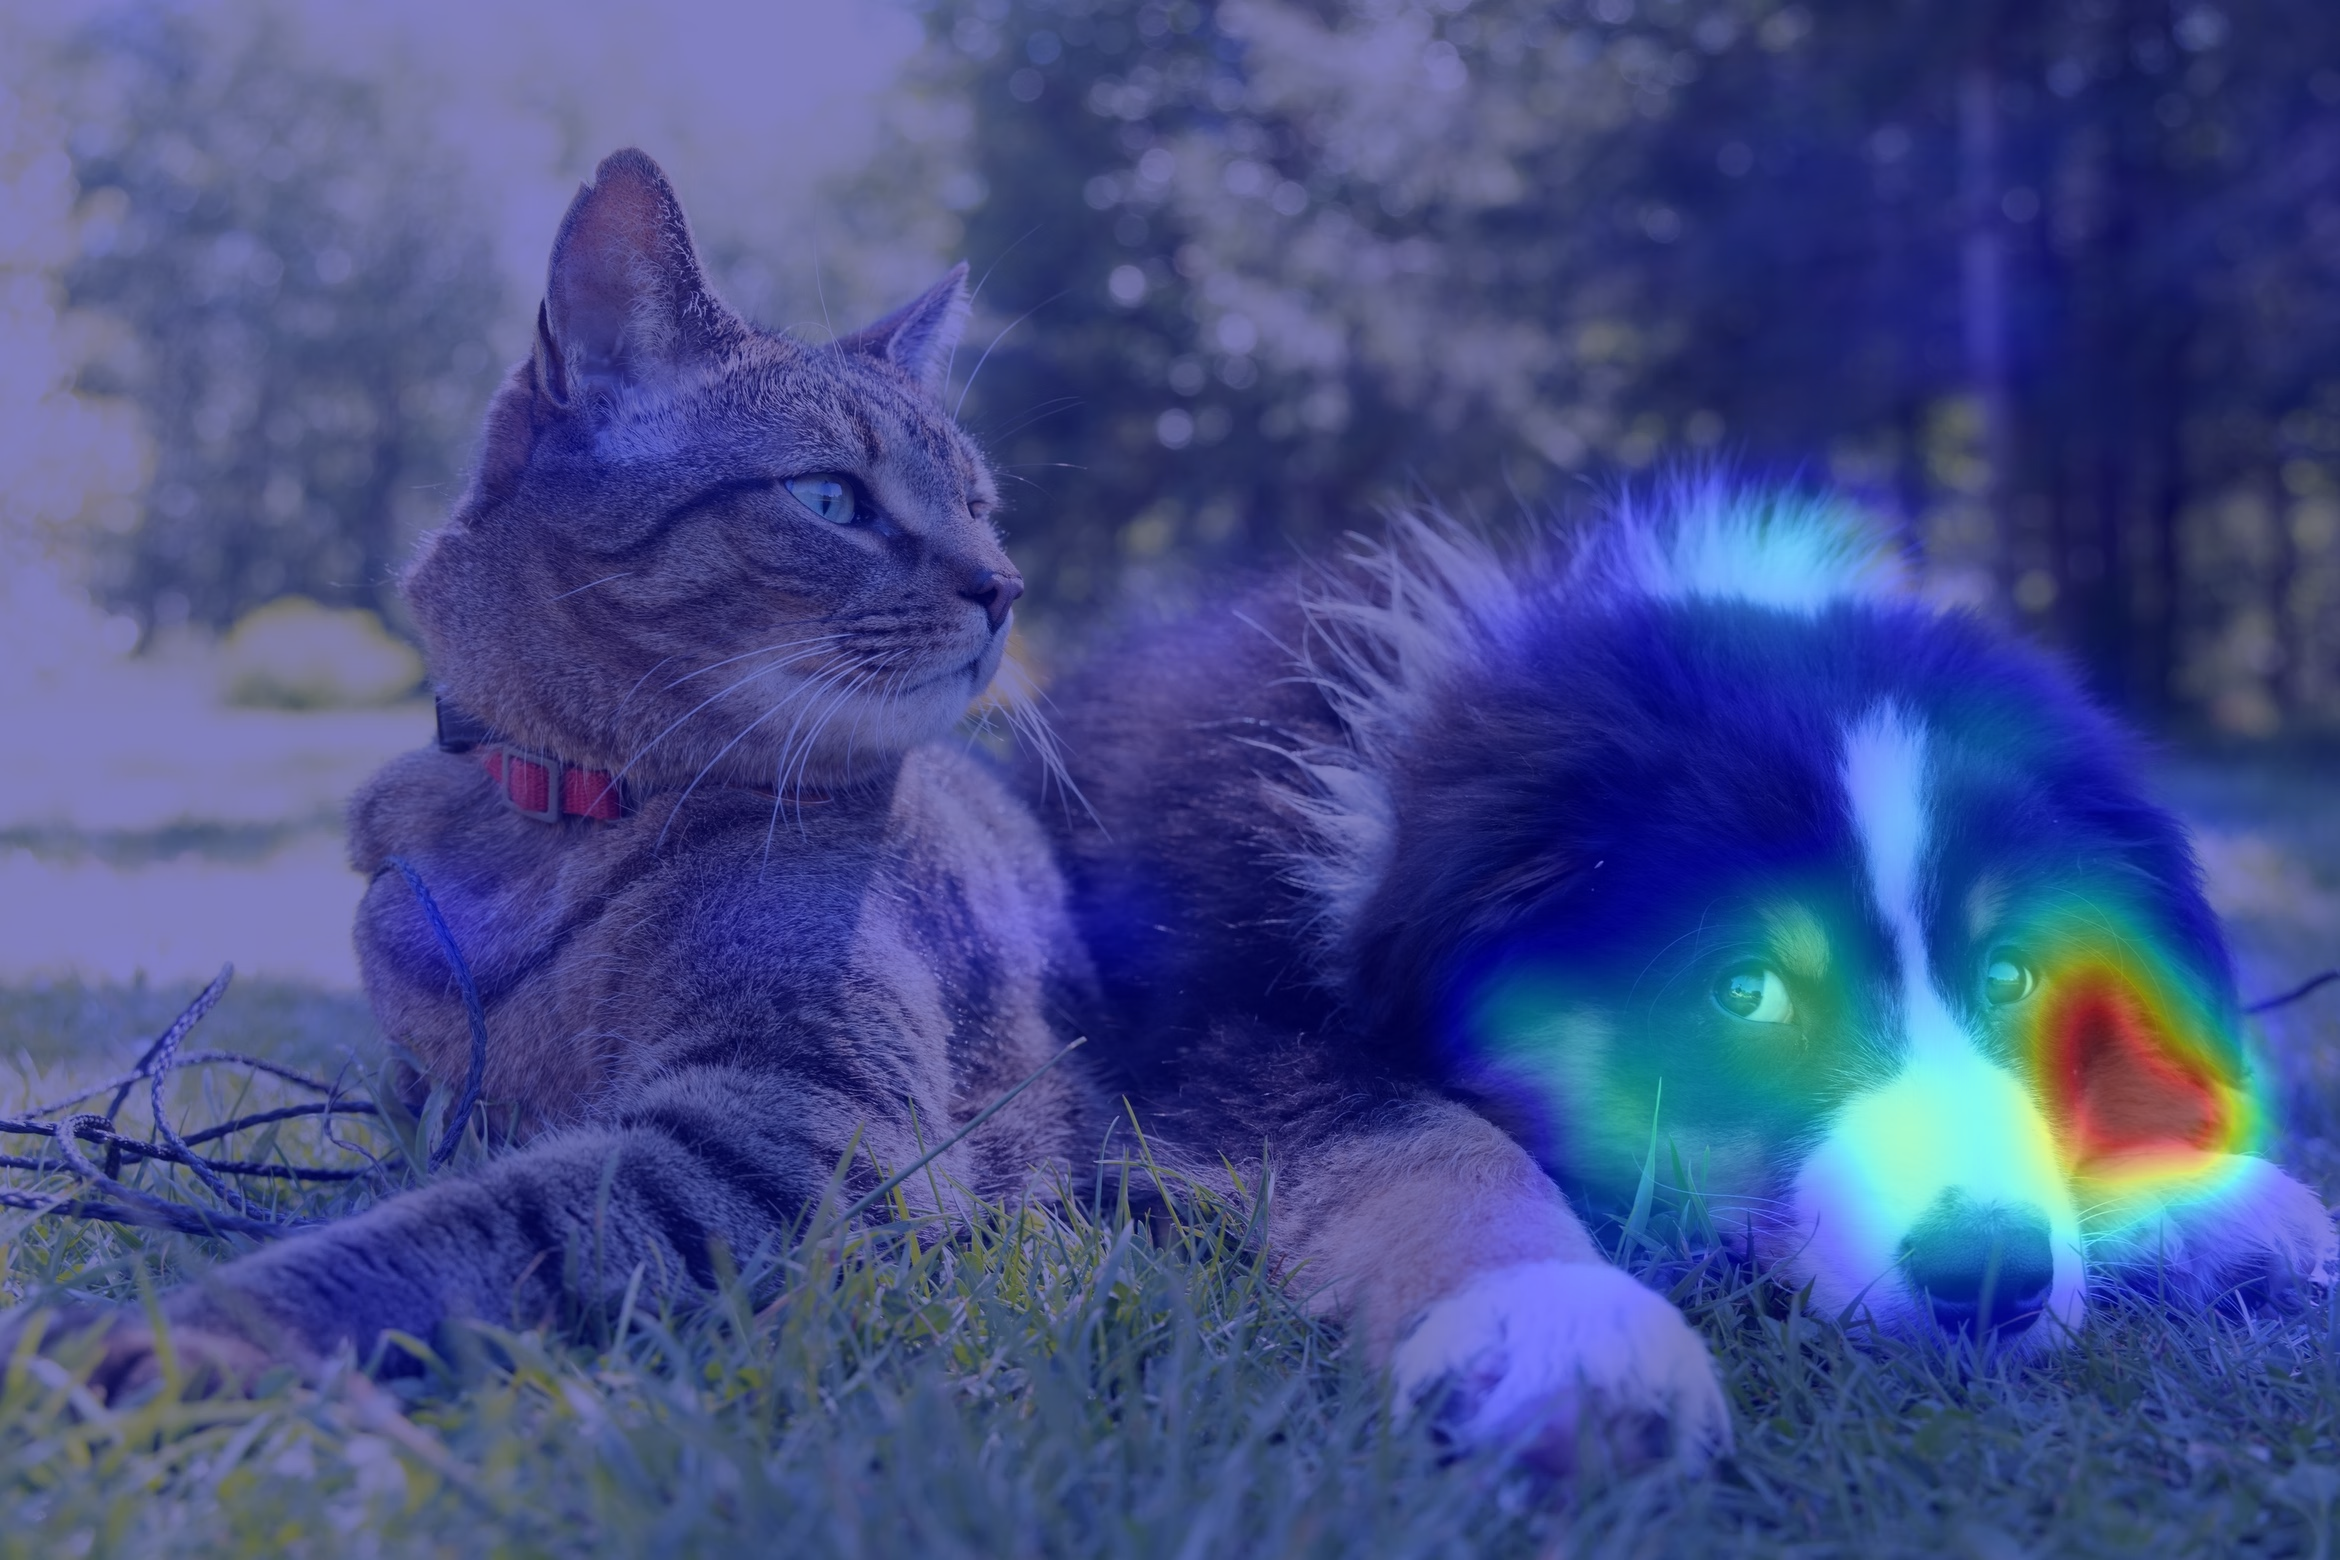

In [20]:
result.show()

In [21]:
result.save(save_path)